In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class MDP:
    '''A simple MDP class.  It includes the following members'''

    def __init__(self,T,R,discount):
        '''Constructor for the MDP class

        Inputs:
        T -- Transition function: |A| x |S| x |S'| array
        R -- Reward function: |A| x |S| array
        discount -- discount factor: scalar in [0,1)

        The constructor verifies that the inputs are valid and sets
        corresponding variables in a MDP object'''

        assert T.ndim == 3, "Invalid transition function: it should have 3 dimensions"
        self.nActions = T.shape[0]
        self.nStates = T.shape[1]
        assert T.shape == (self.nActions,self.nStates,self.nStates), "Invalid transition function: it has dimensionality " + repr(T.shape) + ", but it should be (nActions,nStates,nStates)"
        assert (abs(T.sum(2)-1) < 1e-5).all(), "Invalid transition function: some transition probability does not equal 1"
        self.T = T
        assert R.ndim == 2, "Invalid reward function: it should have 2 dimensions" 
        assert R.shape == (self.nActions,self.nStates), "Invalid reward function: it has dimensionality " + repr(R.shape) + ", but it should be (nActions,nStates)"
        self.R = R
        assert 0 <= discount < 1, "Invalid discount factor: it should be in [0,1)"
        self.discount = discount
        
    def valueIteration(self,initialV,nIterations=np.inf,tolerance=0.01):
        '''Value iteration procedure
        V <-- max_a R^a + gamma T^a V

        Inputs:
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''
        
        # temporary values to ensure that the code compiles until this
        # function is coded
        V = initialV
        iterId = 0
        epsilon = np.inf
        
        while (iterId < nIterations and epsilon > tolerance):
          iterId += 1
          V_matrix = []
          for i in range(self.nActions):
            V_matrix.append(self.R[i]+self.discount*self.T[i] @ V)
          V_next = np.amax(np.array(V_matrix), 0)
          epsilon = np.max(np.abs(V_next - V))
          V = V_next
          
        return [V,iterId,epsilon]
          

    def extractPolicy(self,V):
        '''Procedure to extract a policy from a value function
        pi <-- argmax_a R^a + gamma T^a V

        Inputs:
        V -- Value function: array of |S| entries

        Output:
        policy -- Policy: array of |S| entries'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = np.zeros(self.nStates)
        
        V_matrix = []
        for i in range(self.nActions):
          V_matrix.append(self.R[i]+self.discount*self.T[i] @ V)
        policy = np.array(V_matrix).argmax(0)

        return policy 

    def evaluatePolicy(self,policy):
        '''Evaluate a policy by solving a system of linear equations
        V^pi = R^pi + gamma T^pi V^pi

        Input:
        policy -- Policy: array of |S| entries

        Ouput:
        V -- Value function: array of |S| entries'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = np.zeros(self.nStates)
        
        R_pi = np.zeros(self.nStates)
        for i in range(self.nStates):
          R_pi[i] = self.R[policy[i]][i]
        
        T_pi = np.zeros([self.nStates,self.nStates])
        for i in range(self.nStates):
          T_pi[i] = self.T[policy[i]][i]
        
        V = np.linalg.pinv(np.identity(self.nStates) - self.discount*T_pi) @ R_pi

        return V
        
    def policyIteration(self,initialPolicy,nIterations=np.inf):
        '''Policy iteration procedure: alternate between policy
        evaluation (solve V^pi = R^pi + gamma T^pi V^pi) and policy
        improvement (pi <-- argmax_a R^a + gamma T^a V^pi).

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        nIterations -- limit on # of iterations: scalar (default: inf)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = np.zeros(self.nStates)
        iterId = 0
        
        while(iterId < nIterations):
          iterId += 1
          V = self.evaluatePolicy(policy)
          policy_next = self.extractPolicy(V)
          if np.array_equal(policy, policy_next):
            return [policy,V,iterId]
          policy = policy_next
          
        return [policy, V, iterId]
          
    def evaluatePolicyPartially(self,policy,initialV,nIterations=np.inf,tolerance=0.01):
        '''Partial policy evaluation:
        Repeat V^pi <-- R^pi + gamma T^pi V^pi

        Inputs:
        policy -- Policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = initialV
        iterId = 0
        epsilon = np.inf
        
        R_pi = np.zeros(self.nStates)
        for i in range(self.nStates):
          R_pi[i] = self.R[policy[i]][i]
        
        T_pi = np.zeros([self.nStates,self.nStates])
        for i in range(self.nStates):
          T_pi[i] = self.T[policy[i]][i]
          
        while(iterId < nIterations and epsilon > tolerance):
          iterId += 1
          V_next = R_pi + self.discount*T_pi @ V
          epsilon = np.max(np.abs(V_next - V))
          V = V_next

        return [V,iterId,epsilon]

    def modifiedPolicyIteration(self,initialPolicy,initialV,nEvalIterations=5,nIterations=np.inf,tolerance=0.01):
        '''Modified policy iteration procedure: alternate between
        partial policy evaluation (repeat a few times V^pi <-- R^pi + gamma T^pi V^pi)
        and policy improvement (pi <-- argmax_a R^a + gamma T^a V^pi)

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nEvalIterations -- limit on # of iterations to be performed in each partial policy evaluation: scalar (default: 5)
        nIterations -- limit on # of iterations to be performed in modified policy iteration: scalar (default: inf)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = initialV
        iterId = 0
        epsilon = np.inf
        
        while(iterId < nIterations and epsilon > tolerance):
          iterId += 1
          [V, _, _] = self.evaluatePolicyPartially(policy,V,nEvalIterations,tolerance=0.01)
          policy = self.extractPolicy(V)
          [V_next, _, _] = self.valueIteration(V,1)
          epsilon = np.max(np.abs(V_next - V))
          

        return [policy,V,iterId,epsilon]
        

Value Iteration:
Value function [31.49636306 38.51527513 43.935435   54.1128575 ]
Number of Iteration 58
Policy [0 1 1 1]

Policy Iteration:
Value function [31.58510431 38.60401638 44.02417625 54.20159875]
Number of Iteration 2
Policy [0 1 1 1]

Modified Policy Iteration:
Value function [31.49636306 38.51527513 43.935435   54.1128575 ]
Number of Iteration 13
Policy [0 1 1 1]



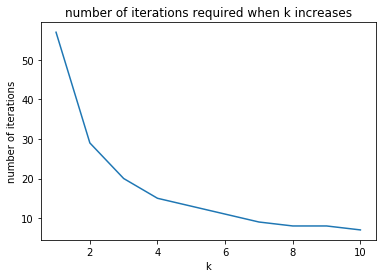

In [6]:
''' Construct simple MDP as described in Lecture 2a Slides 13-14'''
# Transition function: |A| x |S| x |S'| array
T = np.array([[[0.5,0.5,0,0],[0,1,0,0],[0.5,0.5,0,0],[0,1,0,0]],[[1,0,0,0],[0.5,0,0,0.5],[0.5,0,0.5,0],[0,0,0.5,0.5]]])
# Reward function: |A| x |S| array
R = np.array([[0,0,10,10],[0,0,10,10]])
# Discount factor: scalar in [0,1)
discount = 0.9        
# MDP object
mdp = MDP(T,R,discount)

'''Test each procedure'''
[V,nIterations,epsilon] = mdp.valueIteration(initialV=np.zeros(mdp.nStates))
policy = mdp.extractPolicy(V)
print("Value Iteration:\nValue function {}\nNumber of Iteration {}\nPolicy {}\n".format(V,nIterations,policy))
#V = mdp.evaluatePolicy(np.array([1,0,1,0]))
[policy,V,iterId] = mdp.policyIteration(np.array([0,0,0,0]))
print("Policy Iteration:\nValue function {}\nNumber of Iteration {}\nPolicy {}\n".format(V,iterId,policy))
#[V,iterId,epsilon] = mdp.evaluatePolicyPartially(np.array([1,0,1,0]),np.array([0,10,0,13]))

[policy,V,iterId,tolerance] = mdp.modifiedPolicyIteration(np.array([0,0,0,0]),np.array([0,0,0,0]))
print("Modified Policy Iteration:\nValue function {}\nNumber of Iteration {}\nPolicy {}\n".format(V,iterId,policy))

iterId_lst=[]
for i in range(10):
  [_,_,iterId,_] = mdp.modifiedPolicyIteration(np.zeros(mdp.nStates,dtype=np.int),np.zeros(mdp.nStates),nEvalIterations=i+1)
  iterId_lst.append(iterId)
  
plt.title("number of iterations required when k increases")
plt.xlabel("k")
plt.ylabel("number of iterations")
_=plt.plot(np.arange(10)+1, iterId_lst)


##Analysis for the impact of the number of iterations in partial policy evaluation on the results
As the number of iterations in partial policy evaluation increases, the modified policy iteration converges faster but the rate slows down and eventaully reaches a plain. when k is small the modified policy iteration approaches value iteration and when k is large, the modified policy iteration approaches policy iteration as the partial policy evaluation approaches true policy evaluation of policy iteration.

In [23]:
class RL:
    def __init__(self,mdp,sampleReward):
        '''Constructor for the RL class

        Inputs:
        mdp -- Markov decision process (T, R, discount)
        sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
        This function takes one argument: the mean of the distributon and 
        returns a sample from the distribution.
        '''

        self.mdp = mdp
        self.sampleReward = sampleReward

    def sampleRewardAndNextState(self,state,action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action,state])
        cumProb = np.cumsum(self.mdp.T[action,state,:])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward,nextState]

    def qLearning(self,s0,initialQ,nEpisodes,nSteps,epsilon=0,temperature=1):
        '''qLearning algorithm.  Epsilon exploration and Boltzmann exploration
        are combined in one procedure by sampling a random action with 
        probabilty epsilon and performing Boltzmann exploration otherwise.  
        When epsilon and temperature are set to 0, there is no exploration.

        Inputs:
        s0 -- initial state
        initialQ -- initial Q function (|A|x|S| array)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random
        temperature -- parameter that regulates Boltzmann exploration

        Outputs: 
        Q -- final Q function (|A|x|S| array)
        policy -- final policy
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        Q = initialQ
        n_table = np.zeros(Q.shape,dtype=int)
        learning_rate = 0
        episodeId = 0
        reward_episodes = []
        while (episodeId < nEpisodes):
          episodeId += 1
          s=s0
          reward_cum=0
          stepId = 0
          while (stepId < nSteps):
            stepId += 1
            action = 0
            if (np.random.rand(1) < epsilon):
              action = np.random.randint(self.mdp.nActions)
            elif (temperature != 0):
              boltz_state = np.exp(Q[:,s].flatten() / temperature)
              boltz_state = boltz_state / boltz_state.sum()
              boltz_state = np.cumsum(boltz_state)
              action = np.where(boltz_state >= np.random.rand(1))[0][0]
            else:
              action = Q[:,s].argmax()
              print (action)
            [reward, s_next] = self.sampleRewardAndNextState(s,action)
            n_table[action,s] += 1
            learning_rate = 1 / n_table[action,s]
            Q[action,s] = Q[action,s] + learning_rate*(reward + self.mdp.discount*np.max(Q[:,s_next].flatten())-Q[action,s])
            s = s_next
            reward_cum += reward
          reward_episodes.append(reward_cum)
        
        policy = Q.argmax(0).flatten()

        return [Q,policy, reward_episodes]    

----------------------------------------------------------------------------------------------------[3 1 1 1 3 3 1 1 2 1 1 2 0 3 3 2 1]
----------------------------------------------------------------------------------------------------[3 1 1 1 3 3 1 1 0 3 3 1 3 1 3 0 0]
----------------------------------------------------------------------------------------------------[3 1 3 1 3 3 3 1 2 3 3 1 3 3 3 3 2]
----------------------------------------------------------------------------------------------------[3 3 1 1 1 3 1 1 1 3 3 1 3 3 3 1 1]


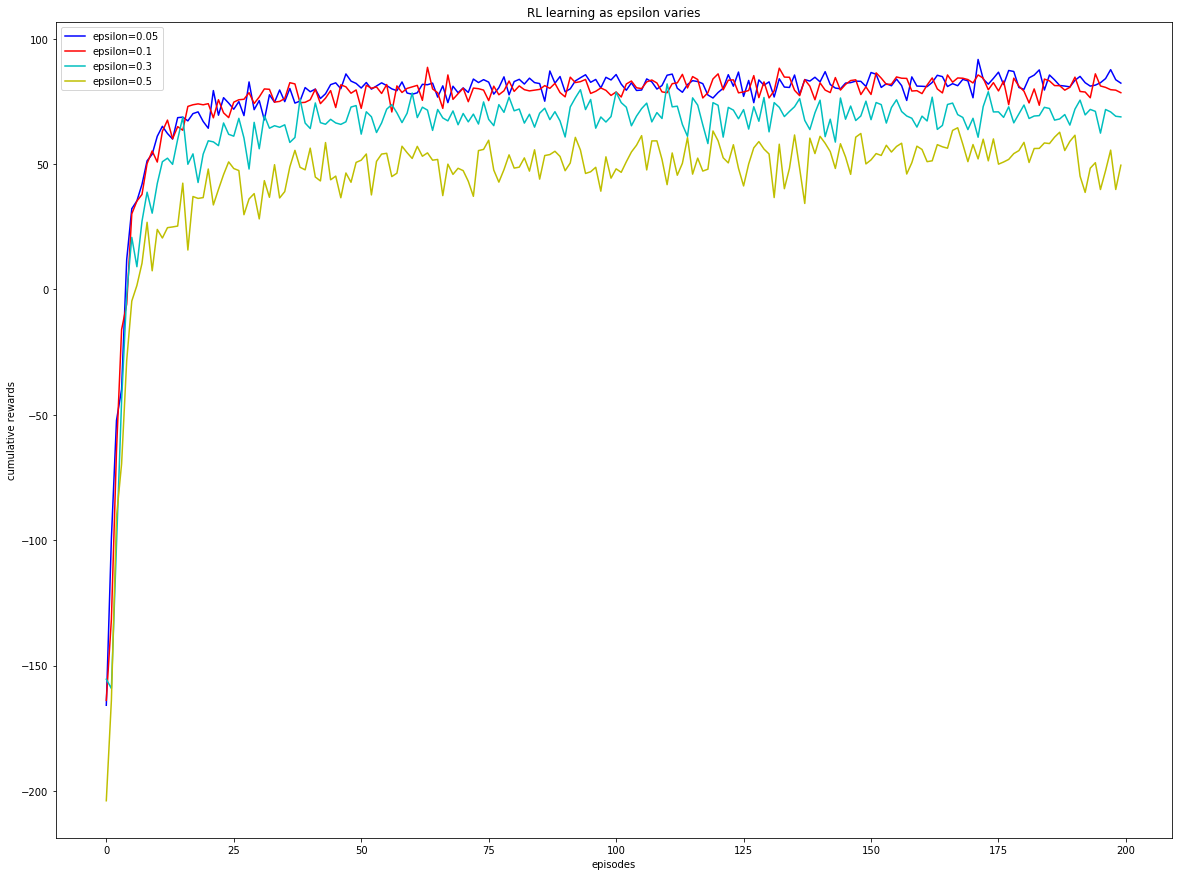

In [24]:


import sys

''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 15 
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions 
  to after visiting the goal state.

  There are 17 states in total (including the end state) 
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4,17,17])
a = 0.8;  # intended move
b = 0.1;  # lateral move

# up (a = 0)

T[0,0,0] = a+b;
T[0,0,1] = b;

T[0,1,0] = b;
T[0,1,1] = a;
T[0,1,2] = b;

T[0,2,1] = b;
T[0,2,2] = a;
T[0,2,3] = b;

T[0,3,2] = b;
T[0,3,3] = a+b;

T[0,4,4] = b;
T[0,4,0] = a;
T[0,4,5] = b;

T[0,5,4] = b;
T[0,5,1] = a;
T[0,5,6] = b;

T[0,6,5] = b;
T[0,6,2] = a;
T[0,6,7] = b;

T[0,7,6] = b;
T[0,7,3] = a;
T[0,7,7] = b;

T[0,8,8] = b;
T[0,8,4] = a;
T[0,8,9] = b;

T[0,9,8] = b;
T[0,9,5] = a;
T[0,9,10] = b;

T[0,10,9] = b;
T[0,10,6] = a;
T[0,10,11] = b;

T[0,11,10] = b;
T[0,11,7] = a;
T[0,11,11] = b;

T[0,12,12] = b;
T[0,12,8] = a;
T[0,12,13] = b;

T[0,13,12] = b;
T[0,13,9] = a;
T[0,13,14] = b;

T[0,14,13] = b;
T[0,14,10] = a;
T[0,14,15] = b;

T[0,15,16] = 1;
T[0,16,16] = 1;

# down (a = 1)

T[1,0,0] = b;
T[1,0,4] = a;
T[1,0,1] = b;

T[1,1,0] = b;
T[1,1,5] = a;
T[1,1,2] = b;

T[1,2,1] = b;
T[1,2,6] = a;
T[1,2,3] = b;

T[1,3,2] = b;
T[1,3,7] = a;
T[1,3,3] = b;

T[1,4,4] = b;
T[1,4,8] = a;
T[1,4,5] = b;

T[1,5,4] = b;
T[1,5,9] = a;
T[1,5,6] = b;

T[1,6,5] = b;
T[1,6,10] = a;
T[1,6,7] = b;

T[1,7,6] = b;
T[1,7,11] = a;
T[1,7,7] = b;

T[1,8,8] = b;
T[1,8,12] = a;
T[1,8,9] = b;

T[1,9,8] = b;
T[1,9,13] = a;
T[1,9,10] = b;

T[1,10,9] = b;
T[1,10,14] = a;
T[1,10,11] = b;

T[1,11,10] = b;
T[1,11,15] = a;
T[1,11,11] = b;

T[1,12,12] = a+b;
T[1,12,13] = b;

T[1,13,12] = b;
T[1,13,13] = a;
T[1,13,14] = b;

T[1,14,13] = b;
T[1,14,14] = a;
T[1,14,15] = b;

T[1,15,16] = 1;
T[1,16,16] = 1;

# left (a = 2)

T[2,0,0] = a+b;
T[2,0,4] = b;

T[2,1,1] = b;
T[2,1,0] = a;
T[2,1,5] = b;

T[2,2,2] = b;
T[2,2,1] = a;
T[2,2,6] = b;

T[2,3,3] = b;
T[2,3,2] = a;
T[2,3,7] = b;

T[2,4,0] = b;
T[2,4,4] = a;
T[2,4,8] = b;

T[2,5,1] = b;
T[2,5,4] = a;
T[2,5,9] = b;

T[2,6,2] = b;
T[2,6,5] = a;
T[2,6,10] = b;

T[2,7,3] = b;
T[2,7,6] = a;
T[2,7,11] = b;

T[2,8,4] = b;
T[2,8,8] = a;
T[2,8,12] = b;

T[2,9,5] = b;
T[2,9,8] = a;
T[2,9,13] = b;

T[2,10,6] = b;
T[2,10,9] = a;
T[2,10,14] = b;

T[2,11,7] = b;
T[2,11,10] = a;
T[2,11,15] = b;

T[2,12,8] = b;
T[2,12,12] = a+b;

T[2,13,9] = b;
T[2,13,12] = a;
T[2,13,13] = b;

T[2,14,10] = b;
T[2,14,13] = a;
T[2,14,14] = b;

T[2,15,16] = 1;
T[2,16,16] = 1;

# right (a = 3)

T[3,0,0] = b;
T[3,0,1] = a;
T[3,0,4] = b;

T[3,1,1] = b;
T[3,1,2] = a;
T[3,1,5] = b;

T[3,2,2] = b;
T[3,2,3] = a;
T[3,2,6] = b;

T[3,3,3] = a+b;
T[3,3,7] = b;

T[3,4,0] = b;
T[3,4,5] = a;
T[3,4,8] = b;

T[3,5,1] = b;
T[3,5,6] = a;
T[3,5,9] = b;

T[3,6,2] = b;
T[3,6,7] = a;
T[3,6,10] = b;

T[3,7,3] = b;
T[3,7,7] = a;
T[3,7,11] = b;

T[3,8,4] = b;
T[3,8,9] = a;
T[3,8,12] = b;

T[3,9,5] = b;
T[3,9,10] = a;
T[3,9,13] = b;

T[3,10,6] = b;
T[3,10,11] = a;
T[3,10,14] = b;

T[3,11,7] = b;
T[3,11,11] = a;
T[3,11,15] = b;

T[3,12,8] = b;
T[3,12,13] = a;
T[3,12,12] = b;

T[3,13,9] = b;
T[3,13,14] = a;
T[3,13,13] = b;

T[3,14,10] = b;
T[3,14,15] = a;
T[3,14,14] = b;

T[3,15,16] = 1;
T[3,16,16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4,17]);

# set rewards
R[:,15] = 100;  # goal state
R[:,9] = -70;   # bad state
R[:,16] = 0;    # end state

# Discount factor: scalar in [0,1)
discount = 0.95
        
# MDP object
mdp = MDP(T,R,discount)

# RL problem
rlProblem = RL(mdp,np.random.normal)

# Test Q-learning
plt.figure(figsize=(20,15))
history_lst=[]
policy = []
for i in range(100):
  print('-',end='')
  [Q,policy,history] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.05)
  history_lst.append(history)
_=plt.plot(range(200),np.average(history_lst,axis=0),'-b', label='epsilon=0.05')
print(policy)

history_lst=[]
for i in range(100):
  print('-',end='')
  [Q,policy,history] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.1)
  history_lst.append(history)
_=plt.plot(range(200),np.average(history_lst,axis=0),'-r', label='epsilon=0.1')
print(policy)

history_lst=[]
for i in range(100):
  print('-',end='')
  [Q,policy,history] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.3)
  history_lst.append(history)
_=plt.plot(range(200),np.average(history_lst,axis=0),'-c', label='epsilon=0.3')
print(policy)

history_lst=[]
for i in range(100):
  print('-',end='')
  [Q,policy,history] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.5)
  history_lst.append(history)
_=plt.plot(range(200),np.average(history_lst,axis=0),'-y', label='epsilon=0.5')
print(policy)

plt.legend()
plt.xlabel("episodes")
plt.ylabel("cumulative rewards")
plt.title("RL learning as epsilon varies")
plt.show()


##The impact of the exploration probability epsilon on the cumulative rewards per episode earned during training
As shown in the graph above, at the beginning of the training before the cumulative rewards converge to the optimal value, larger epsilon or larger exploration rate speed up the convergence to optimal cumulative rewards while smaller exploration rate might lead to sub-optimal solutions. Therefore, smaller epsilon leads to less cumulative rewards and the variance of the cumulative rewards tend to be larger. After learning from enough episodes, models with different epsilon (as long as epsilon is not zero) will all converge to the optimal solution, but the model with larger epsilon keep exploring more after convergence resulting in the larger variance in the cumulative rewards after convergence. Eventually all the models with epsilon greater than zero and less than 1 will converge to the optimal solution. The cumulative reward is also a good indicator of the Q values during learning as the convergence of Q values results in the convergence of policy and thus the rewards obtained in a stochastic manner.

In [9]:
!pip install gym

In [18]:
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(100):
    #env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
